In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import normalize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

import xgboost as xgb

from scipy import stats

%matplotlib inline


### Load Data

In [2]:
df = pd.read_csv('train.csv')
orig_df = pd.read_csv('train.csv')

In [3]:
df.shape

(26729, 10)

In [4]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [5]:
df['Breed'].unique().shape

(1380,)

In [6]:
df.columns.values

array(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color'], dtype=object)

### Convert Age column to age in years

In [7]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [8]:
df['AgeuponOutcome'].unique()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years', nan,
       '17 years', '18 years', '19 years', '20 years'], dtype=object)

In [9]:
nrows = len(df['AgeuponOutcome'])
Ages = df['AgeuponOutcome'].astype(str)
y = np.zeros((nrows))

for i in range(nrows):
    
    if 'year' in Ages[i]:
        y[i] = (float(Ages[i].split()[0]))
    
    elif 'week' in Ages[i]:
        y[i] = (float(Ages[i].split()[0])/52.)
        
    elif 'month' in Ages[i]:
        y[i] = (float(Ages[i].split()[0])/12.)
        
    elif 'day' in Ages[i]:
        y[i] = (float(Ages[i].split()[0])/352.)
        
    else:
        y[i] = -99 
#     print y[i]

In [10]:
y[y == -99] = np.mean(y[y != -99])

#### Here, we replace the missing ages with the average age of the animals

In [11]:
df['AgeuponOutcome'] = pd.DataFrame({'AgeuponOutcome': y.tolist()})

In [12]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1.000000,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1.000000,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2.000000,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,0.057692,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2.000000,Lhasa Apso/Miniature Poodle,Tan


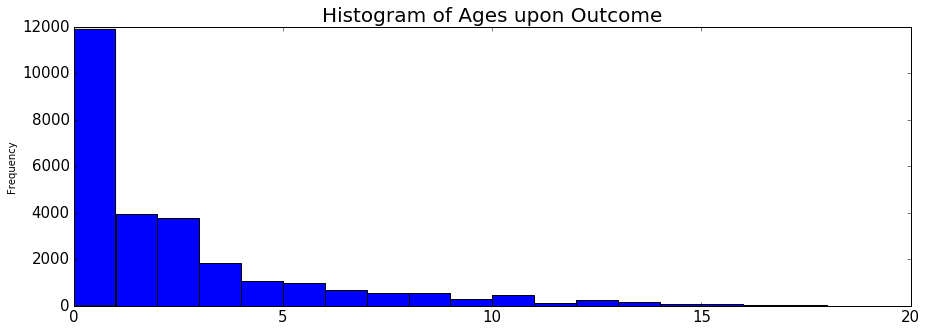

In [13]:
%matplotlib inline
plt.figure(figsize = (15,5))
df['AgeuponOutcome'].plot.hist(20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Histogram of Ages upon Outcome', fontsize = 20)

## Basic Stats for Dogs vs Cats

#### Average age upon Outcome

In [14]:
df[df['AnimalType'] == 'Dog']['AgeuponOutcome'].mean()

2.7590384739991176

In [15]:
df[df['AnimalType'] == 'Cat']['AgeuponOutcome'].mean()

1.3623559083926418

#### Number of dogs vs cats

In [16]:
len(df[df['AnimalType'] == 'Dog'])

15595

In [17]:
len(df[df['AnimalType'] == 'Cat'])

11134

## Create columns for male vs female, fixed vs intact

In [18]:
df['SexuponOutcome'].unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

In [19]:
df['SexuponOutcome'] = df['SexuponOutcome'].replace(np.nan,'')

In [20]:
spayed_neutered = np.zeros( (len(df['SexuponOutcome']) ))
sex = np.zeros((len(df['SexuponOutcome'])))
for i in range(len(df['SexuponOutcome'])):
#     print df['SexuponOutcome'][i]
    x = df['SexuponOutcome'][i].split()
    if ('Neutered' in x) | ('Spayed' in x):
        spayed_neutered[i] = 1.
    if ('Male' in x):
        sex[i] = 1.
        

In [21]:
np.sum(spayed_neutered)/len(df)

0.69583598338882857

#### Note: Only 69.5% of animals in the shelter are Spayed or Neutered

In [22]:
np.sum(sex)/len(df)

0.49773654083579633

#### About 50% of animals are male

In [23]:
df['Fixed'] = pd.DataFrame({'fixed':spayed_neutered})
df['Male'] = pd.DataFrame({'Male': sex})

df = df.drop('SexuponOutcome',1)

Convert Sex and Neutered Columns

## Simplify the Breed Feature

In [24]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,AgeuponOutcome,Breed,Color,Fixed,Male
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,1.000000,Shetland Sheepdog Mix,Brown/White,1.0,1.0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,1.000000,Domestic Shorthair Mix,Cream Tabby,1.0,0.0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,2.000000,Pit Bull Mix,Blue/White,1.0,1.0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,0.057692,Domestic Shorthair Mix,Blue Cream,0.0,1.0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,2.000000,Lhasa Apso/Miniature Poodle,Tan,1.0,1.0


In [25]:
len(df['Breed'].unique())

1380

###### Currently, there are 1380 different breed classifications among cats and dogs

In [26]:
df['Breed'].value_counts()[0:10]

Domestic Shorthair Mix       8810
Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
Domestic Medium Hair Mix      839
German Shepherd Mix           575
Domestic Longhair Mix         520
Siamese Mix                   389
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Name: Breed, dtype: int64

In [27]:
df[df['AnimalType'] == 'Cat']['Breed'].value_counts()[0:10]

Domestic Shorthair Mix      8810
Domestic Medium Hair Mix     839
Domestic Longhair Mix        520
Siamese Mix                  389
Domestic Shorthair           143
Snowshoe Mix                  75
Maine Coon Mix                44
Manx Mix                      44
Domestic Medium Hair          42
Russian Blue Mix              33
Name: Breed, dtype: int64

In [28]:
len(df[df['AnimalType'] == 'Cat']['Breed'].unique())

60

In [29]:
len(df[df['AnimalType'] == 'Dog']['Breed'].unique())

1320

#### Domestic Shorthair Mix seems to be a classification for cats only

- Cat breeds seem to be somewhat limited with 60 different breeds while dogs have 1320 different classifications. We will only simplify dog breeds.

In [30]:
df[df['AnimalType'] == 'Dog']['Breed'].value_counts()[0:20]

Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
German Shepherd Mix           575
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Boxer Mix                     245
Miniature Poodle Mix          233
Border Collie Mix             229
Australian Shepherd Mix       163
Rat Terrier Mix               157
Catahoula Mix                 157
Jack Russell Terrier Mix      146
Yorkshire Terrier Mix         143
Chihuahua Longhair Mix        142
Siberian Husky Mix            138
Miniature Schnauzer Mix       136
Beagle Mix                    124
Rottweiler Mix                113
American Bulldog Mix          109
Name: Breed, dtype: int64

In [31]:
import re

dog_breeds = list(df[df['AnimalType'] == 'Dog']['Breed'])
for i in range(len(dog_breeds)):
    if ('Mix' in dog_breeds[i]):
        dog_breeds[i] = re.sub(' Mix', '', dog_breeds[i])
    else:
        dog_breeds[i] = dog_breeds[i].split("/")[0]
    
            

###### Let's remove the "Mix" from the dog breeds and also take only the first breed from classifications in the form "breed 1 / breed 2", assuming that the first breed listed is the dominant breed

In [32]:
dog_breeds_df = pd.DataFrame({'Breed':dog_breeds})

In [33]:
len(dog_breeds_df['Breed'].unique())

188

###### We were able to narrow down the different classes of dog breeds from 1320 to 188

In [34]:
dog_breeds_df['Breed'].value_counts()[0:10]

Chihuahua Shorthair      2145
Pit Bull                 2113
Labrador Retriever       1915
German Shepherd           826
Australian Cattle Dog     511
Dachshund                 510
Boxer                     360
Border Collie             334
Miniature Poodle          310
Australian Shepherd       229
Name: Breed, dtype: int64

###### Now let's replace all the dog breed classifications from the original dataframe with the new breed classifications

In [35]:
df.ix[df.AnimalType == 'Dog', 'Breed'] = dog_breeds

In [36]:
len(df['Breed'].unique())

248

## Simplify Dog Color Column

###### Now, let's simplify the color Column

In [37]:
len(df['Color'].unique())

366

In [38]:
len(df[df['AnimalType'] == 'Dog']['Color'].unique())

262

In [39]:
df[df['AnimalType'] == 'Dog']['Color'].value_counts()[0:15]

Black/White            1730
Brown/White             882
Black                   851
White                   806
Tan/White               773
Tricolor                751
Black/Tan               672
Brown                   637
Tan                     627
White/Brown             562
White/Black             475
Brown Brindle/White     450
Black/Brown             435
Blue/White              414
White/Tan               389
Name: Color, dtype: int64

In [40]:
df[df['AnimalType'] == 'Cat']['Color'].value_counts()[0:15]

Brown Tabby           1635
Black                 1441
Black/White           1094
Brown Tabby/White      940
Orange Tabby           841
Tortie                 530
Calico                 517
Orange Tabby/White     455
Blue Tabby             433
Blue                   385
Torbie                 335
Blue/White             288
Blue Tabby/White       241
Cream Tabby            198
White/Black            168
Name: Color, dtype: int64

#### We will take the dominant color

In [41]:
colors = df['Color']
color = [c.split("/")[0] for c in df['Color']]

In [42]:
len(pd.DataFrame({'Color':color})['Color'].unique())

57

In [43]:
pd.DataFrame({'Color':color})['Color'].value_counts()[0:15]

Black            6422
White            3344
Brown Tabby      2592
Brown            1951
Tan              1674
Orange Tabby     1299
Blue             1199
Tricolor          800
Red               779
Brown Brindle     699
Blue Tabby        678
Tortie            580
Calico            552
Chocolate         448
Torbie            398
Name: Color, dtype: int64

** Taking the first listed color as the dominant color, we reduced the number of possibilites for color definition from 366 to 57 **

In [44]:
df['Color'] = color

In [45]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,AgeuponOutcome,Breed,Color,Fixed,Male
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,1.000000,Shetland Sheepdog,Brown,1.0,1.0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,1.000000,Domestic Shorthair Mix,Cream Tabby,1.0,0.0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,2.000000,Pit Bull,Blue,1.0,1.0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,0.057692,Domestic Shorthair Mix,Blue Cream,0.0,1.0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,2.000000,Lhasa Apso,Tan,1.0,1.0


## Simplify the date and time column
- Let's divide the dates into seasons of the year

In [46]:
df['DateTime'].head()

0    2014-02-12 18:22:00
1    2013-10-13 12:44:00
2    2015-01-31 12:28:00
3    2014-07-11 19:09:00
4    2013-11-15 12:52:00
Name: DateTime, dtype: object

In [47]:
from datetime import datetime
d = df['DateTime'][0].split()[0]
date = datetime.strptime(d, '%Y-%m-%d')

In [48]:
season = []
for i in range(len(df['DateTime'])):
    d = df['DateTime'][i].split()[0]
    date = datetime.strptime(d, '%Y-%m-%d')
    if (date.month >= 11):
        season.append('Winter')
    elif (date.month == 1):
        season.append('Winter')
    elif (date.month >= 2) & (date.month <= 5):
        season.append('Spring')
    elif (date.month >= 6) & (date.month <= 8):
        season.append('Summer')
    else:
        season.append('Fall')
        
df['Season'] = season
# month = []
# for i in range(len(df['DateTime'])):
#     d = df['DateTime'][i].split()[0]
#     date = datetime.strptime(d, '%Y-%m-%d')
#     if (date.month == 1):
#         month.append('January')
#     elif (date.month == 2):
#         month.append('February')
#     elif (date.month == 3):
#         month.append('March')
#     elif (date.month == 4):
#         month.append('April')
#     elif (date.month == 5):
#         month.append('May')
#     elif (date.month == 6):
#         month.append('June')
#     elif (date.month == 7):
#         month.append('July')
#     elif (date.month == 8):
#         month.append('August')
#     elif (date.month == 9):
#         month.append('September')
#     elif (date.month == 10):
#         month.append('October')
#     elif (date.month == 11):
#         month.append('November')
#     else:
#         month.append('December')
# df['Month'] = month

In [49]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,AgeuponOutcome,Breed,Color,Fixed,Male,Season
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,1.000000,Shetland Sheepdog,Brown,1.0,1.0,Spring
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,1.000000,Domestic Shorthair Mix,Cream Tabby,1.0,0.0,Fall
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,2.000000,Pit Bull,Blue,1.0,1.0,Winter
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,0.057692,Domestic Shorthair Mix,Blue Cream,0.0,1.0,Summer
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,2.000000,Lhasa Apso,Tan,1.0,1.0,Winter


### Create Dummy Variables for Columns with Categorical Variables

In [50]:
# cat_var = ['Color', 'Breed', 'Month']
cat_var = ['Color', 'Breed', 'Season']

def dummy(df, list):
    for x in cat_var:
        df1 = pd.get_dummies(df[x])
        df = df.drop(x,axis = 1)
        df = pd.concat([df,df1], axis = 1)
    return df

In [51]:
dat = dummy(df, cat_var)

In [52]:
# from copy import copy
# dat = copy(df)
# le = LabelEncoder()
# le.fit(df['Color'])
# dat['Color'] = le.transform(dat['Color'])

# le.fit(df['Breed'])
# dat['Breed'] = le.transform(dat['Breed'])

# le.fit(df['Month'])
# dat['Month'] = le.transform(dat['Month'])

In [53]:
dat.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,AgeuponOutcome,Fixed,Male,Agouti,...,Welsh Terrier,West Highland,Whippet,Wire Hair Fox Terrier,Wirehaired Pointing Griffon,Yorkshire Terrier,Fall,Spring,Summer,Winter
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,1.000000,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,1.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,2.000000,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,0.057692,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,2.000000,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Check dimensions of data frame to check dummy function

In [54]:
len(dat.columns.values)

318

In [55]:
len(df.columns.values)

12

In [56]:
len(df['Breed'].unique()) + len(df['Color'].unique()) + len(df['Season'].unique()) - 2 + 11

318

### Create Indicator Column whether the animal was given a name or not

In [57]:
# df['Name'].value_counts(dropna = False)?


In [58]:
dat['Name'] = df['Name'].isnull() * 1.
dat = dat.rename(columns = {'Name':'NoName'})

In [59]:
dat.head()

,AnimalID,NoName,DateTime,OutcomeType,OutcomeSubtype,AnimalType,AgeuponOutcome,Fixed,Male,Agouti,...,Welsh Terrier,West Highland,Whippet,Wire Hair Fox Terrier,Wirehaired Pointing Griffon,Yorkshire Terrier,Fall,Spring,Summer,Winter
0,A671945,0.0,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,1.000000,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,A656520,0.0,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,1.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,A686464,0.0,2015-01-31 12:28:00,Adoption,Foster,Dog,2.000000,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,A683430,1.0,2014-07-11 19:09:00,Transfer,Partner,Cat,0.057692,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,A667013,1.0,2013-11-15 12:52:00,Transfer,Partner,Dog,2.000000,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Create column for indicator of Animal Type

In [60]:
df['AnimalType'].unique()

array(['Dog', 'Cat'], dtype=object)

In [61]:
dat['AnimalType'] = (df['AnimalType'] == 'Dog') * 1.

### Create Labels

In [62]:
lab = dat['OutcomeType']

In [63]:
len(lab)

26729

In [64]:
# labels = (lab != 'Euthanasia') * 1.

In [65]:
lab.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [66]:
le = LabelEncoder()
labels = le.fit_transform(dat['OutcomeType'])


### Drop columns not needed for models

In [67]:
dat.drop(['AnimalID','DateTime','OutcomeType','OutcomeSubtype'],axis = 1).dtypes.unique()

array([dtype('float64')], dtype=object)

In [68]:
dat = dat.drop(['AnimalID','DateTime','OutcomeType','OutcomeSubtype'],axis = 1)

In [69]:
dat.head()

,NoName,AnimalType,AgeuponOutcome,Fixed,Male,Agouti,Apricot,Black,Black Brindle,Black Smoke,...,Welsh Terrier,West Highland,Whippet,Wire Hair Fox Terrier,Wirehaired Pointing Griffon,Yorkshire Terrier,Fall,Spring,Summer,Winter
0,0.0,1.0,1.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,2.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.057692,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,2.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Create Training and Testing Sets

In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(dat, labels, test_size = 0.25)

In [77]:
len(X_train)/float(len(dat))

0.7499719405888735

In [78]:

X_train = normalize(X_train, axis = 0)
X_test = normalize(X_test, axis = 0)

### Xgboost

In [89]:
xgb_model1 = xgb.XGBClassifier(n_estimators = 150, learning_rate = 0.005)

In [90]:
xgb_model1.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.005, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=150, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [91]:
xgb_model1.score(X_test, Y_test)

0.62292383660032924

### Logistic Regression

In [86]:
lm = LogisticRegression(penalty = 'l1', multi_class = 'ovr', C = 1.0)
lm.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [87]:
lm.score(X_test, Y_test)

0.63594194224150835

In [88]:
log_loss(Y_test, lm.predict_proba(X_test))

1.0171928351057682

### Logistic Regression Grid Search and Cross Validation

In [109]:
log_model = LogisticRegression(penalty = 'l1')
params = {'C':[0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]}
gs_model = GridSearchCV(log_model, params)
gs_model.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [110]:
gs_model.best_params_

{'C': 3.5}

In [111]:
best_log_model = LogisticRegression(C = 3.5, penalty = 'l1')
best_log_model.fit(X_train, Y_train)
best_log_model.score(X_test, Y_test)

0.63294927427801884

In [112]:
log_loss(Y_test, best_log_model.predict_proba(X_test))

1.0427300341214494

[[2401    0    4  201   94]
 [   6    0    3    3   34]
 [  88    0   46   92  157]
 [ 703    0    7  481   60]
 [ 779    0   35  187 1302]]


array(['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'], dtype=object)

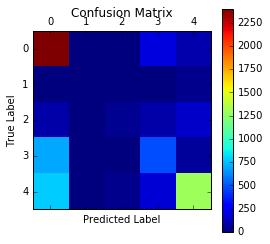

In [137]:
cm = confusion_matrix(Y_test, best_log_model.predict(X_test))

plt.matshow(cm)
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

print cm

le.classes_

In [206]:
log_model_cv = LogisticRegressionCV(Cs = 10, penalty = 'l1', solver = 'liblinear', multi_class = 'ovr')

In [207]:
log_model_cv.fit(X_test, Y_test)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [208]:
log_model_cv.C_

array([  3.59381366e-01,   1.00000000e-04,   1.00000000e-04,
         2.78255940e+00,   2.78255940e+00])

In [215]:
log_model2 = LogisticRegression(C = 2.78, penalty = 'l1')

In [216]:
log_model2.fit(X_train, Y_train)

LogisticRegression(C=2.78, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [217]:
log_model2.score(X_test, Y_test)

0.63354780787071674

In [218]:
log_loss(Y_test, log_model2.predict_proba(X_test))

1.0382296238475253

### Random Forest

In [175]:
rf_model1 = RandomForestClassifier(n_estimators = 150)
rf_model1.fit(X_train, Y_train)
rf_model1.score(X_test, Y_test)

0.58312135268591947

In [176]:
log_loss(Y_test, rf_model1.predict_proba(X_test))

1.5430824002527641

### SVM

In [ ]:
svm_model1 = svm.SVC(C = 0.5, kernel = 'linear')

In [ ]:
svm_model1.fit(X_train, Y_train)

In [ ]:
svm_model1.score(X_test, Y_test)

In [ ]:
params = {'C':[2.5, 3, 3.5]}
grid_search_svm = GridSearchCV(svm.SVC(kernel = 'linear'), params, verbose = 3)
grid_search_svm.fit(X_train, Y_train)

### Gradient Boosting

In [83]:
gb_model1 = GradientBoostingClassifier(n_estimators = 300)

In [84]:
gb_model1.fit(X_train,Y_train)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [85]:
gb_model1.score(X_test, Y_test)

0.63534340864881045

In [94]:
log_loss(Y_test, gb_model1.predict_proba(X_test))

0.89456946775462554

In [86]:
# gb_model.feature_importances_

### Grid Search for Gradient Boosting

In [87]:
params = {'n_estimators': [100, 150, 200], 'learning_rate':[0.1, 0.5], 'max_depth':[2,3,4,5]}
gb_model2 = GradientBoostingClassifier()
grid_search_gb = GridSearchCV(gb_model2, params, verbose = 3)
# grid_search_gb.fit(X_train, Y_train)

In [88]:
# grid_search_gb.best_params_

In [113]:
best_gb_model = GradientBoostingClassifier(n_estimators = 150, learning_rate = 0.1, max_depth = 5)
best_gb_model.fit(X_train, Y_train)
best_gb_model.score(X_test, Y_test)

0.6274128385455634

In [114]:
log_loss(Y_test, best_gb_model.predict_proba(X_test))

0.89567979311668355

[[1974    3   28  513  182]
 [   2    0    4    3   37]
 [  29    1   92  108  153]
 [ 372    0   48  734   97]
 [ 532   10   88  280 1393]]


array(['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'], dtype=object)

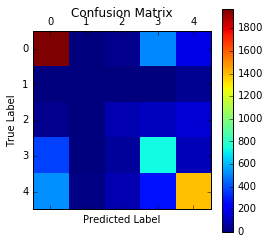

In [179]:
cm = confusion_matrix(Y_test, best_gb_model.predict(X_test))

plt.matshow(cm)
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

print cm

le.classes_

In [124]:
feat_imp = pd.DataFrame({'features':dat.columns.values,'values':best_gb_model.feature_importances_})

In [125]:
feat_imp.sort('values').iloc[-15:]

/home/truong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,features,values
54,Tan,0.004135
701,Domestic Shorthair,0.005697
7,Black,0.006283
59,White,0.008462
20,Brown,0.008711
1128,Pit Bull Mix,0.009931
1442,Fall,0.010625
1445,Winter,0.013475
1,AnimalType,0.016629
1444,Summer,0.016747


### SGD Classifier

In [182]:
sgd_model1 = SGDClassifier(loss = 'log', penalty = 'l1', l1_ratio = 1.0, n_iter = 10)
sgd_model1.fit(X_train, Y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=1.0, learning_rate='optimal',
       loss='log', n_iter=10, n_jobs=1, penalty='l1', power_t=0.5,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [183]:
sgd_model1.score(X_test, Y_test)

0.55962890917252728

In [184]:
np.unique(sgd_model1.predict(X_test))

array([0, 3, 4])

In [185]:
log_loss(Y_test, sgd_model1.predict_proba(X_test))

1.0716622391925847

### ZeroR Baseline

In [92]:
stats.mode(labels)

ModeResult(mode=array([0]), count=array([10769]))

In [93]:
10769./len(labels)

0.40289573122825395

# Summary:
** Using the zero rule baseline, we would get a 40% accuracy by "guessing" all dogs will be adopted. Using numerous models, the best result is 64% prediction accuracy, a 24% increase, using the Logistic Regression with a L-1 penalty. **